In [1]:
!pip install metpy
!pip install netCDF4
!pip install siphon


In [2]:
from datetime import datetime, timedelta

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np

from metpy.plots import StationPlot
from metpy.units import units
from netCDF4 import Dataset, num2date
from scipy.ndimage import gaussian_filter
from siphon.catalog import TDSCatalog

In [4]:
## Case Study Date
# year = 2017
# month = 7
# day = 1
# hour = 3

# dt = datetime(year, month, day, hour)

In [5]:
# from siphon.catalog import TDSCatalog
# top_cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog.xml')
# top_cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-narr-b-files/catalog.xml')
# top_cat = TDSCatalog('https://rda.ucar.edu/thredds/catalog/files/g/ds608.0/3HRLY/2017/catalog.xml')

In [7]:
from calendar import monthrange
from datetime import datetime
import itertools

from netCDF4 import date2num, num2date
import numpy as np
from pyproj import Proj
from siphon.catalog import TDSCatalog
import xarray as xr

base_catalog = 'http://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/NARR/pressure/catalog.xml'
# base_catalog = 'http://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/NARR/subsurface/catalog.xml'
base_catalog = 'http://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/NARR/monolevel/catalog.xml'
main_cat = TDSCatalog(base_catalog)

# Spatial location to find stuff
points = [(69 , -135), (70, -134)]
lats, lons = map(np.array, zip(*points))
# fields = ['uwnd','vwnd']
fields = ['ulwrf.ntat']

# for year, month, var in itertools.product(([2017]), range(6, 7),
#     dsname = '{}.{:4d}{:02d}.nc'.format(var, year, month)
# fields):

for year, var in itertools.product(([2017]),fields):
    # Figure out what to grab
    dsname = '{}.{:4d}.nc'.format(var, year)
    print('{}: downloading...'.format(dsname), end='')

    # Grab it using opendap--manually convert to CF to work around the
    # fact that missing_value and _FillValue differ
    ds = xr.open_dataset(main_cat.datasets[dsname].access_urls['OPENDAP'],
                         decode_cf=False)
    ds = xr.conventions.decode_cf(ds, mask_and_scale=False)

    # Grab the projection variable and convert our points to that
    # Probably not strictly necessary
    if var == 'air.2m':
        var = 'air'
    proj_var = ds[ds[var].grid_mapping]
    proj = Proj(proj='lcc', lat_0=proj_var.latitude_of_projection_origin,
            lon_0=proj_var.longitude_of_central_meridian,
            lat_1=proj_var.standard_parallel[0],
lat_2=proj_var.standard_parallel[1],
            x_0=proj_var.false_easting, y_0=proj_var.false_northing,
ellps='sphere')
    x, y = proj(lons, lats)
    # Subset the data
    print('subsetting...', end='')
#     ds.
    pt_ds = ds.sel(x=x, y=y, method='nearest')
    print('saving...', end='')

    # Save to disk
    pt_ds.to_netcdf('Data/'+dsname)
    print('done.')

ulwrf.ntat.2017.nc: downloading...

RuntimeError: NetCDF: Access failure

In [21]:
print(ds)
# plt.figure()
# plt.scatter(lons,lats)

<xarray.Dataset>
Dimensions:            (time: 2920, x: 349, y: 277)
Coordinates:
  * time               (time) datetime64[ns] 2017-01-01 ... 2017-12-31T21:00:00
  * y                  (y) float32 0.0 32463.0 64926.0 ... 8927325.0 8959788.0
  * x                  (x) float32 0.0 32463.0 64926.0 ... 11264660.0 11297120.0
    lat                (y, x) float32 ...
    lon                (y, x) float32 ...
Data variables:
    Lambert_Conformal  int32 ...
    air                (time, y, x) float32 ...
Attributes:
    Conventions:                     CF-1.2
    centerlat:                       50.0
    centerlon:                       -107.0
    comments:                        
    institution:                     National Centers for Environmental Predi...
    latcorners:                      [ 1.000001  0.897945 46.3544   46.63433 ]
    loncorners:                      [-145.5       -68.32005    -2.569891  14...
    platform:                        Model
    standardpar1:                

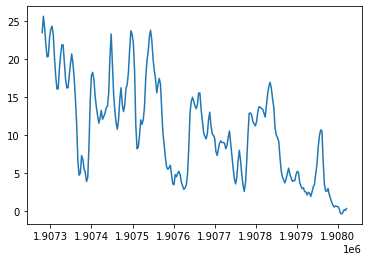

In [15]:
my_example_nc_file = 'air.201708.nc'
fh = Dataset(my_example_nc_file, mode='r')
time=fh.variables['time'][:]
# print(fh.variables)
lons = fh.variables['lon'][:]
lats = fh.variables['lat'][:]
air = fh.variables['air'][:]
# tmax = fh.variables['uwnd'][:]
# print(fh.variables['uwnd'].shape)
# print(fh.variables['uwnd'].shape)

# print(tmax[:,0,:,:].mean(axis=1).mean(axis=1).shape)

air = fh.variables['air'][:]
air_units = fh.variables['air'].units
fh.close()

# print(time[-1]-time[0])
# print(lons)
plt.figure()
plt.plot(time,air[:,0,0,0]-273.15)
# plt.plot(time,(vwnd[:,0,0,0]**2+uwnd[:,0,0,0]**2)**.5)
# plt.plot(time,(vwnd[:,0,0,0]**2+uwnd[:,0,0,0]**2)**.5)
# plt.plot(time,180 +180/np.pi*np.arctan2(uwnd[:,0,0,0],vwnd[:,0,0,0]))
# plt.plot(time,tmax[:,0,1,1])#-273.15)

# print(tmax.shape[0]/31)

In [23]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap
# # Get some parameters for the Stereographic Projection
# lon_0 = lons.mean()
# lat_0 = lats.mean()

# m = Basemap(width=5000000,height=3500000,
#             resolution='l',projection='stere',\
#             lat_ts=40,lat_0=lat_0,lon_0=lon_0)

# # Because our lon and lat variables are 1D,
# # use meshgrid to create 2D arrays
# # Not necessary if coordinates are already in 2D arrays.
lon, lat = np.meshgrid(lons, lats)
xi, yi = m(lon, lat)

# # Plot Data
plt.figure()
cs = plt.pcolor(xi,yi,np.squeeze(tmax))

# Add Grid Lines
m.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()

# Add Colorbar
cbar = m.colorbar(cs, location='bottom', pad="10%")
cbar.set_label(tmax_units)

# Add Title
plt.title('DJF Maximum Temperature')

plt.show()

NameError: name 'm' is not defined

In [63]:
# Read NARR Data from THREDDS server
base_url = 'https://www.ncei.noaa.gov/thredds/catalog/model-narr-a-files/'

# Programmatically generate the URL to the day of data we want
cat = TDSCatalog(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/catalog.xml')

print(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/catalog.xml')

# Have Siphon find the appropriate dataset
ds = cat.datasets.filter_time_nearest(dt)
print(cat.datasets)
# Interface with the data through the NetCDF Subset Service (NCSS)
ncss = ds.subset()

# Create an NCSS query with our desired specifications
query = ncss.query()
query.lonlat_box(north=60, south=18, east=300, west=225)
query.all_times()
query.add_lonlat()
query.accept('netcdf')
query.variables('Geopotential_height_isobaric',
                'Temperature_isobaric',
                'u-component_of_wind_isobaric',
                'v-component_of_wind_isobaric')

# Use the query to obtain our NetCDF data
data = ncss.get_data(query)

https://www.ncei.noaa.gov/thredds/catalog/model-narr-a-files/200007/20000701/catalog.xml
['narr-a_221_20000701_2100_000.grb', 'narr-a_221_20000701_1800_000.grb', 'narr-a_221_20000701_1500_000.grb', 'narr-a_221_20000701_1200_000.grb', 'narr-a_221_20000701_0900_000.grb', 'narr-a_221_20000701_0600_000.grb', 'narr-a_221_20000701_0300_000.grb', 'narr-a_221_20000701_0000_000.grb']


In [81]:
import xarray as xr
from siphon.catalog import TDSCatalog
cat_url = 'https://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/NARR/Dailies/pressure/catalog.xml'
cat = TDSCatalog(cat_url)
dsets = [cds.remote_access(use_xarray=True).reset_coords(drop=True).chunk({'time': 1, 'level': 1})
         for cds in cat.datasets[:1]] # eventually want to use the whole catalog here
# ds = xr.auto_combine(dsets)
dsets

/opt/conda/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[<xarray.Dataset>
 Dimensions:            (level: 29, nbnds: 2, time: 31, x: 349, y: 277)
 Coordinates:
   * time               (time) datetime64[ns] 1979-01-01 ... 1979-01-31
   * level              (level) float32 1000.0 975.0 950.0 ... 150.0 125.0 100.0
   * y                  (y) float32 0.0 32463.0 64926.0 ... 8927325.0 8959788.0
   * x                  (x) float32 0.0 32463.0 64926.0 ... 11264660.0 11297120.0
 Dimensions without coordinates: nbnds
 Data variables:
     Lambert_Conformal  int32 ...
     time_bnds          (time, nbnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
     air                (time, level, y, x) float32 dask.array<chunksize=(1, 1, 277, 349), meta=np.ndarray>
 Attributes:
     Conventions:                     CF-1.2
     centerlat:                       50.0
     centerlon:                       -107.0
     comments:                        
     institution:                     National Centers for Environmental Predi...
     latcorners:        

In [45]:
data.dimensions

{'time1': <class 'netCDF4._netCDF4.Dimension'>: name = 'time1', size = 1,
 'isobaric1': <class 'netCDF4._netCDF4.Dimension'>: name = 'isobaric1', size = 29,
 'y': <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 117,
 'x': <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 90}

In [46]:
# Extract data and assign units
tmpk = gaussian_filter(data.variables['Temperature_isobaric'][0], sigma=1.0) * units.K
hght = 0
uwnd = 0
vwnd = 0

# Extract coordinate data for plotting
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]
lev = 0

In [47]:
# %load solutions/extract.py

# Cell content replaced by load magic replacement.
# Extract data and assign units
tmpk = gaussian_filter(data.variables['Temperature_isobaric'][0],
                       sigma=1.0) * units.K
hght = gaussian_filter(data.variables['Geopotential_height_isobaric'][0],
                       sigma=1.0) * units.meter
uwnd = gaussian_filter(data.variables['u-component_of_wind_isobaric'][0], sigma=1.0) * units('m/s')
vwnd = gaussian_filter(data.variables['v-component_of_wind_isobaric'][0], sigma=1.0) * units('m/s')

# Extract coordinate data for plotting
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]
lev = data.variables['isobaric1'][:]

In [48]:
time = data.variables['time1']
print(time.units)
vtime = num2date(time[0], units=time.units)
# print(vtime)
print(lat.max())
print(lat.min())
print(lon.max())
print(lon.min())


Hour since 1993-03-13T00:00:00Z
50.62094969918222
12.810807198301989
-115.21944040068476
-155.04513482886856


In [11]:
# Calcualte dx and dy for calculations
dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)

In [12]:
# Specify 850 hPa data
ilev850 = np.where(lev==850)[0][0]
hght_850 = hght[ilev850]
tmpk_850 = 0
uwnd_850 = 0
vwnd_850 = 0

In [13]:
# Specify 500 hPa data
ilev500 = 0
hght_500 = 0
uwnd_500 = 0
vwnd_500 = 0

In [14]:
# Specify 300 hPa data
ilev300 = 0
hght_300 = 0
uwnd_300 = 0
vwnd_300 = 0

In [15]:
# %load solutions/get_850_500_300.py

# Cell content replaced by load magic replacement.
# Specify 850 hPa data
ilev850 = np.where(lev == 850)[0][0]
hght_850 = hght[ilev850]
tmpk_850 = tmpk[ilev850]
uwnd_850 = uwnd[ilev850]
vwnd_850 = vwnd[ilev850]

# Specify 500 hPa data
ilev500 = np.where(lev == 500)[0][0]
hght_500 = hght[ilev500]
uwnd_500 = uwnd[ilev500]
vwnd_500 = vwnd[ilev500]

# Specify 300 hPa data
ilev300 = np.where(lev == 300)[0][0]
hght_300 = hght[ilev300]
uwnd_300 = uwnd[ilev300]
vwnd_300 = vwnd[ilev300]

In [16]:
print(data)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Originating_or_generating_Center: US National Weather Service, National Centres for Environmental Prediction (NCEP)
    Originating_or_generating_Subcenter: North American Regional Reanalysis Project
    GRIB_table_version: 0,131
    Generating_process_or_model: North American Regional Reanalysis (NARR)
    Conventions: CF-1.6
    history: Read using CDM IOSP GribCollection v3
    featureType: GRID
    History: Translated to CF-1.0 Conventions by Netcdf-Java CDM (CFGridWriter2)
Original Dataset = DatasetScan#narr-a_221_19930313_0000_000.grb; Translation Date = 2020-09-08T20:03:32.264Z
    geospatial_lat_min: 10.753308882144761
    geospatial_lat_max: 46.8308828962289
    geospatial_lon_min: -153.88242040519995
    geospatial_lon_max: -42.666108129242815
    dimensions(sizes): time1(1), isobaric1(29), y(119), x(268)
    variables(dimensions): float32 Geopotential_height_isobaric(time1, i